In [1]:
from pathlib import Path

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import models

from sklearn.metrics import confusion_matrix
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision


/root/miniconda3/envs/COMP9444/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Utilities Section
# RGB format
index_color_mapping={0:(0,0,0),         # void
                     1:(108,64,20),     # dirt
                     2:(255,229,204),   # sand
                     3:(0,102,0),       # grass
                     4:(0,255,0),       # tree
                     5:(0,153,153),     # pole
                     6:(0,128,255),     # water
                     7:(0,0,255),       # sky
                     8:(255,255,0),     # vehicle
                     9:(255,0,127),     # container/generic-object
                     10:(64,64,64),     # asphalt
                     11:(255,128,0),    # gravel
                     12:(255,0,0),      # building
                     13:(153,76,0),     # mulch
                     14:(102,102,0),    # rock-bed
                     15:(102,0,0),      # log
                     16:(0,255,128),    # bicycle
                     17:(204,153,255),  # person
                     18:(102,0,204),    # fence
                     19:(255,153,204),  # bush
                     20:(0,102,102),    # sign
                     21:(153,204,255),  # rock
                     22:(102,255,255),  # bridge
                     23:(101,101,11),   # concrete
                     24:(114,85,47)}    # picnic-table

# RGB format
color_index_mapping={(0,0,0):0,         # void
                     (108,64,20):1,     # dirt
                     (255,229,204):2,   # sand
                     (0,102,0):3,       # grass
                     (0,255,0):4,       # tree
                     (0,153,153):5,     # pole
                     (0,128,255):6,     # water
                     (0,0,255):7,       # sky
                     (255,255,0):8,     # vehicle
                     (255,0,127):9,     # container/generic-object
                     (64,64,64):10,     # asphalt
                     (255,128,0):11,    # gravel
                     (255,0,0):12,      # building
                     (153,76,0):13,     # mulch
                     (102,102,0):14,    # rock-bed
                     (102,0,0):15,      # log
                     (0,255,128):16,    # bicycle
                     (204,153,255):17,  # person
                     (102,0,204):18,    # fence
                     (255,153,204):19,  # bush
                     (0,102,102):20,    # sign
                     (153,204,255):21,  # rock
                     (102,255,255):22,  # bridge
                     (101,101,11):23,   # concrete
                     (114,85,47):24}    # picnic-table     

def index_lookup(color:tuple)->int:
    """
    Get index of color from color_index_mapping where the format of color is RGB.\n
    Therefore, you must convert color format to RGB before you pass variable 'color'\n
    The variable 'color' is a tuple.
    """
    return color_index_mapping[color]

def to_color_label(index_label:np.ndarray) -> np.ndarray:
    """
    Convert index label to color label for showing the result of prediction.
    """
    h,w=index_label.shape
    color_label=np.zeros((h,w,3),dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            color=index_color_mapping[index_label[i][j]]
            r,g,b=color
            color_label[i][j]=np.array([b,g,r])
    return color_label

def get_dirs_list(dir_path:Path)->list:
    return [p for p in dir_path.iterdir() if p.is_dir()]

def get_files_list(dir_path:Path,suffix:str)->list:
    return [f for f in dir_path.iterdir() if f.is_file() and f.suffix==suffix]

def process_row(row:np.ndarray)->list:
    index_list=[]
    for element in row:
        bgr=element.tolist()
        rgb=(bgr[2],bgr[1],bgr[0])
        index_list.append(index_lookup(rgb))
    return index_list

def convert_color2index(file_path:str)->np.ndarray:
    color=cv2.imread(file_path,cv2.IMREAD_COLOR)
    rows=[color[i,:] for i in range(color.shape[0])]
    with ThreadPoolExecutor() as executor:
        rst=list(executor.map(process_row,rows))
    return np.array(rst,dtype=np.uint8)

def compute_confusion_matrix_sklearn(pred, target, num_classes, ignore_index=None):
    pred = pred.flatten()
    target = target.flatten()

    if ignore_index is not None:
        mask = target != ignore_index
        pred = pred[mask]
        target = target[mask]

    cm = confusion_matrix(target, pred, labels=np.arange(num_classes))
    return cm

class CustomDataset(Dataset):
    def __init__(self, workspace_path:str, csv_file_name:str, color_transforms=None, target_size=None, loading_mode="pre"):
        workspace_path=Path(workspace_path)
        csv_file_path=workspace_path/csv_file_name
        files_list=np.genfromtxt(csv_file_path,dtype=None,encoding='utf-8',delimiter=',')
        self.num_files=files_list.shape[0]
        self.color_transforms=color_transforms
        self.target_size=target_size
        self.loading_mode=loading_mode

        self.data_file_full_path_list=[]
        for pair in files_list:
            color_file_path=Path(pair[0])
            index_file_path=Path(pair[1])
            self.data_file_full_path_list.append([color_file_path,index_file_path])

        self.color_index_list=None
        if loading_mode=="pre":
            with ThreadPoolExecutor() as executor:
                self.color_index_list=list(tqdm(executor.map(self.__load_color_and_index__,self.data_file_full_path_list),desc="Load images and labels",total=self.__len__()))

    def __load_color_and_index__(self,path_pair)->list:
        color_image_path=path_pair[0]
        index_label_path=path_pair[1]
        color_image=cv2.imread(color_image_path.as_posix(),cv2.IMREAD_UNCHANGED)
        index_label=cv2.imread(index_label_path.as_posix(),cv2.IMREAD_UNCHANGED)
        if self.target_size is not None:
            color_image=cv2.resize(color_image,self.target_size,interpolation=cv2.INTER_LINEAR)
            index_label=cv2.resize(index_label,self.target_size,interpolation=cv2.INTER_NEAREST)
        return[color_image,index_label]

    def __len__(self)->int:
        return self.num_files

    def __getitem__(self, index):
        color_image=None
        index_label=None
        if self.loading_mode=="pre":
            color_image=self.color_index_list[index][0]
            index_label=self.color_index_list[index][1]
        else:
            pair=self.__load_color_and_index__(self.data_file_full_path_list[index])
            color_image=pair[0]
            index_label=pair[1]
            
        if self.color_transforms is not None:
            color_image=self.color_transforms(color_image)
            index_label=torch.from_numpy(index_label).long()
        return color_image,index_label

In [3]:
# Before everything starting, please create a workspace folder named RUGD_ws 
# Move folders RUGD_frames-with-annotations and RUGD_annotations into RUGD_ws
# Create folder model within RUGD_ws
# Set workspace path here
workspace_path="/root/autodl-tmp/RUGD_ws"

frames_folder_name="RUGD_frames-with-annotations"
annotations_folder_name="RUGD_annotations"
annotations_index_folder_name="RUGD_annotations_index"
model_folder_name="model"

random_state=42
random.seed(random_state)

training_folder_list=["park-2","trail","trail-3","trail-4","trail-6","trail-9","trail-10","trail-11","trail-12","trail-14","trail-15","village"]
val_folder_list=["park-8","trail-5"]
testing_folder_list=["creek","park-1","trail-7","trail-13"]

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current used device is {device}")

Current used device is cuda


In [ ]:
# Index labels generation
annotations_path=Path(workspace_path)/annotations_folder_name
annotation_index_path=Path(workspace_path)/annotations_index_folder_name
annotation_index_path.mkdir()
print("Start generating index labels.")
dirs_list=get_dirs_list(annotations_path)
for p in dirs_list:
    new_p=Path(annotation_index_path/p.name)
    new_p.mkdir()
    files_list=get_files_list(p,".png")
    for f in tqdm(files_list,desc=f"folder '{p.name}' is being processed.",total=len(files_list),leave=False):
        cv2.imwrite((new_p/f.name).as_posix(),convert_color2index(f.as_posix()))
print("Generating index labels finishes.")

In [4]:
# Dataset spliting
frames_path=Path(workspace_path)/frames_folder_name
annotations_index_path=Path(workspace_path)/annotations_index_folder_name
saving_path=Path(workspace_path)

print("Start spliting dataset.")
training_data_path_str_list=[]
for folder_name in training_folder_list:
    frame_path_list=get_files_list(frames_path/folder_name,".png")
    for frame_path in frame_path_list:
        index_path=annotations_index_path/frame_path.parent.name/frame_path.name
        training_data_path_str_list.append([frame_path.as_posix(),index_path.as_posix()])
np.savetxt((saving_path/"train_data_path.csv").as_posix(),np.array(training_data_path_str_list),delimiter=',',fmt='%s')
val_data_path_str_list=[]
for folder_name in val_folder_list:
    frame_path_list=get_files_list(frames_path/folder_name,".png")
    for frame_path in frame_path_list:
        index_path=annotations_index_path/frame_path.parent.name/frame_path.name
        val_data_path_str_list.append([frame_path.as_posix(),index_path.as_posix()])
np.savetxt((saving_path/"val_data_path.csv").as_posix(),np.array(val_data_path_str_list),delimiter=',',fmt='%s')
testing_data_path_str_list=[]
for folder_name in testing_folder_list:
    frame_path_list=get_files_list(frames_path/folder_name,".png")
    for frame_path in frame_path_list:
        index_path=annotations_index_path/frame_path.parent.name/frame_path.name
        testing_data_path_str_list.append([frame_path.as_posix(),index_path.as_posix()])
np.savetxt((saving_path/"test_data_path.csv").as_posix(),np.array(testing_data_path_str_list),delimiter=',',fmt='%s')
print("Finish.")

Start spliting dataset.
Finish.


In [4]:
# Standardization_para_calculating
class TrainingDataset(Dataset):
    def __init__(self,workspace_path,training_data_csv_file_name="train_data_path.csv") -> None:
        workspace_path=Path(workspace_path)
        csv_file_path=workspace_path/training_data_csv_file_name
        files_list= np.genfromtxt(csv_file_path.as_posix(),dtype=None,encoding='utf-8',delimiter=',')
        self.frame_path_list=[]
        for s in files_list[:,:1].tolist():
            self.frame_path_list.append(Path(s[0]))

    def __len__(self) -> int:
        return len(self.frame_path_list)
    
    def __getitem__(self, index):
        image=cv2.imread(self.frame_path_list[index].as_posix(),cv2.IMREAD_UNCHANGED)
        image=transforms.ToTensor()(image)
        return image

csv_file_name="train_data_path.csv"
dataset=TrainingDataset(workspace_path,csv_file_name)
data_loader=DataLoader(dataset=dataset,batch_size=32)

sum_bgr=torch.zeros(3,dtype=torch.float64)
num_pixel=0
for images in tqdm(data_loader,desc="Calculate mean: "):
    sum_bgr+=torch.sum(images,[0,2,3])
    num_pixel+=images.size(0)*images.size(2)*images.size(3)
mean=(sum_bgr/num_pixel)
print(f"mean: {mean}")

sum_squared_bgr=torch.zeros(3,dtype=torch.float64)
for images in tqdm(data_loader,desc="Calculate std: "):
    resharped_mean=mean[None, :, None, None]
    difference_value=images-resharped_mean
    squared_difference_value=difference_value**2
    sum_squared_bgr+=squared_difference_value.sum([0,2,3])
std=torch.sqrt(sum_squared_bgr/num_pixel)
print(f"std: {std}")

Calculate mean: 100%|██████████| 150/150 [01:07<00:00,  2.21it/s]


mean: tensor([0.4044, 0.4067, 0.4069], dtype=torch.float64)


Calculate std: 100%|██████████| 150/150 [01:27<00:00,  1.71it/s]

std: tensor([0.2750, 0.2738, 0.2710], dtype=torch.float64)


In [4]:
deeplab_model = models.segmentation.deeplabv3_resnet50(pretrained=True)
deeplab_model.classifier[4] = nn.Conv2d(256, 25, kernel_size=(1, 1), stride=(1, 1))
deeplab_model.aux_classifier[4]=nn.Conv2d(256, 25, kernel_size=(1, 1), stride=(1, 1))

/root/miniconda3/envs/COMP9444/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/COMP9444/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Parameters of training
color_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4044, 0.4067, 0.4069), (0.2750, 0.2738, 0.2710))
])
loading_mode="pre"
num_classes=25
target_size=(512,512)
epochs=200
batch_size=8
learning_rate=0.001

model=deeplab_model
#weights=torch.tensor([0.0,4.0,4.0,2.0,1.0,4.0,4.0,2.0,3.0,4.0,3.0,2.0,3.0,2.0,3.0,3.0,5.0,5.0,3.0,2.0,5.0,4.0,4.0,3.0,4.0]).to(device)
#criterion = nn.CrossEntropyLoss(weight=weights,ignore_index=0)
criterion = nn.CrossEntropyLoss(ignore_index=0)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)
optimizer =optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

metric_val_acc = MulticlassAccuracy(num_classes=num_classes, ignore_index=0)
metric_val_precision = MulticlassPrecision(num_classes=num_classes, average="macro", ignore_index=0)

In [6]:
# Training
training_dataset=CustomDataset(workspace_path,"train_data_path.csv",color_transforms,target_size,loading_mode)
val_dataset=CustomDataset(workspace_path,"val_data_path.csv",color_transforms,target_size,loading_mode)
training_loader=DataLoader(training_dataset,batch_size,shuffle=True,drop_last=True)
val_loader=DataLoader(val_dataset,batch_size,shuffle=True,drop_last=True)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

model=model.to(device)

metric_val_acc=metric_val_acc.to(device)
metric_val_precision=metric_val_precision.to(device)

Load images and labels: 100%|██████████| 733/733 [00:00<00:00, 786.21it/s]


In [8]:
y_training_loss=[]
y_val_loss=[]
y_val_accuracy=[]
y_val_precision=[]
y_val_pixel_wise_acc=[]
y_val_mIoU=[]

for epoch in range(epochs):
    message=f"Current epoch:{epoch+1}/{epochs} "
    model.train()
    training_loss_sum = 0.0
    for images, labels in tqdm(training_loader, desc=message+"Training: ", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        out=outputs['out']
        aux=outputs['aux']
        loss1 = criterion(out, labels)
        loss2 = criterion(aux, labels)
        loss=loss1+0.35*loss2
        loss.backward()
        optimizer.step()
        training_loss_sum += loss.item()
    y_training_loss.append(training_loss_sum / len(training_loader))

    model.eval()
    val_loss_sum = 0.0
    total_confusion_matrix = np.zeros((num_classes, num_classes))
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=message+"validating: ", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            out=outputs['out']
            aux=outputs['aux']
            loss1 = criterion(out, labels)
            loss2 = criterion(aux, labels)
            loss=loss1+0.35*loss2
            val_loss_sum += loss.item()
            pred_labels = torch.argmax(out, dim=1)
            pred_labels_np = pred_labels.cpu().numpy()
            labels_np = labels.cpu().numpy()
            for pred, target in zip(pred_labels_np, labels_np):
                pred = pred.flatten()
                target = target.flatten()
                mask = target != 0
                pred = pred[mask]
                target = target[mask]
                cm = confusion_matrix(target, pred, labels=np.arange(num_classes))
                total_confusion_matrix += cm
            metric_val_acc.update(pred_labels,labels)
            metric_val_precision.update(pred_labels,labels)
    #scheduler.step()
    # mIou
    intersection = np.diag(total_confusion_matrix)
    union = total_confusion_matrix.sum(axis=1) + total_confusion_matrix.sum(axis=0) - intersection
    iou=[1.0 if union[i]==0 else intersection[i] / union[i] for i in range(num_classes)]
    mIoU=sum(iou[1:])/len(iou[1:])
    # pixel-wise accuracy
    correct_pixels = intersection.sum()
    total_pixels = total_confusion_matrix.sum()
    pixel_wise_acc=correct_pixels.item() / total_pixels.item()
    
    y_val_mIoU.append(mIoU)
    y_val_loss.append(val_loss_sum/len(val_loader))
    y_val_accuracy.append(metric_val_acc.compute().item())
    y_val_precision.append(metric_val_precision.compute().item())
    y_val_pixel_wise_acc.append(pixel_wise_acc)
    metric_val_acc.reset()
    metric_val_precision.reset()
    print(f"Epoch: {epoch+1}/{epochs}")
    print(f"Training loss: {y_training_loss[epoch]:.4f} Validation loss: {y_val_loss[epoch]:.4f}")
    print(f"accuracy: {y_val_accuracy[epoch]:.4f} Precision: {y_val_precision[epoch]:.4f}")
    print(f"Pixel-wise Acc: {y_val_pixel_wise_acc[epoch]:.4f} MeanIoU: {y_val_mIoU[epoch]:.4f}")
    if (epoch+1)%50 == 0:
        torch.save(model.state_dict(), Path(workspace_path)/model_folder_name/f"model_{epoch+1}.pth")
    np.savetxt((Path(workspace_path)/model_folder_name/"training_loss.csv").as_posix(),np.array(y_training_loss),delimiter=',',fmt='%f')
    np.savetxt((Path(workspace_path)/model_folder_name/"val_loss.csv").as_posix(),np.array(y_val_loss),delimiter=',',fmt='%f')
    np.savetxt((Path(workspace_path)/model_folder_name/"accuracy.csv").as_posix(),np.array(y_val_accuracy),delimiter=',',fmt='%f')
    np.savetxt((Path(workspace_path)/model_folder_name/"precision.csv").as_posix(),np.array(y_val_precision),delimiter=',',fmt='%f')
    np.savetxt((Path(workspace_path)/model_folder_name/"pixel_wise_acc.csv").as_posix(),np.array(y_val_pixel_wise_acc),delimiter=',',fmt='%f')
    np.savetxt((Path(workspace_path)/model_folder_name/"mIoU.csv").as_posix(),np.array(y_val_mIoU),delimiter=',',fmt='%f')
torch.save(model.state_dict(), Path(workspace_path)/model_folder_name/f"model.pth")


print("Finish!")

Epoch: 1/200
Training loss: 0.6063 Validation loss: 0.7447
accuracy: 0.2567 Precision: 0.3395
Pixel-wise Acc: 0.8412 MeanIoU: 0.3433


Epoch: 2/200
Training loss: 0.5672 Validation loss: 0.7562
accuracy: 0.2723 Precision: 0.2957
Pixel-wise Acc: 0.8169 MeanIoU: 0.3486


Epoch: 3/200
Training loss: 0.5387 Validation loss: 0.5912
accuracy: 0.3110 Precision: 0.3514
Pixel-wise Acc: 0.8660 MeanIoU: 0.3874


Epoch: 4/200
Training loss: 0.5182 Validation loss: 0.5937
accuracy: 0.2914 Precision: 0.3574
Pixel-wise Acc: 0.8645 MeanIoU: 0.3398


Epoch: 5/200
Training loss: 0.5026 Validation loss: 0.5269
accuracy: 0.3298 Precision: 0.3645
Pixel-wise Acc: 0.8822 MeanIoU: 0.3617


Epoch: 6/200
Training loss: 0.4922 Validation loss: 0.5238
accuracy: 0.3423 Precision: 0.3768
Pixel-wise Acc: 0.8827 MeanIoU: 0.4027


Epoch: 7/200
Training loss: 0.4744 Validation loss: 0.5391
accuracy: 0.3307 Precision: 0.3987
Pixel-wise Acc: 0.8768 MeanIoU: 0.3616


Epoch: 8/200
Training loss: 0.4753 Validation loss: 0.5642
accuracy: 0.3425 Precision: 0.3351
Pixel-wise Acc: 0.8775 MeanIoU: 0.3643


Epoch: 9/200
Training loss: 0.4692 Validation loss: 0.6904
accuracy: 0.3051 Precision: 0.3321
Pixel-wise Acc: 0.8353 MeanIoU: 0.3328


Epoch: 10/200
Training loss: 0.4560 Validation loss: 0.5320
accuracy: 0.3240 Precision: 0.4641
Pixel-wise Acc: 0.8792 MeanIoU: 0.4002


Epoch: 11/200
Training loss: 0.4573 Validation loss: 0.5159
accuracy: 0.3111 Precision: 0.3975
Pixel-wise Acc: 0.8850 MeanIoU: 0.3954


Epoch: 12/200
Training loss: 0.4510 Validation loss: 0.5913
accuracy: 0.3610 Precision: 0.3188
Pixel-wise Acc: 0.8653 MeanIoU: 0.3599


Epoch: 13/200
Training loss: 0.4518 Validation loss: 0.5349
accuracy: 0.3328 Precision: 0.4044
Pixel-wise Acc: 0.8773 MeanIoU: 0.3599


Epoch: 14/200
Training loss: 0.4479 Validation loss: 0.5020
accuracy: 0.2991 Precision: 0.4704
Pixel-wise Acc: 0.8902 MeanIoU: 0.3544


Epoch: 15/200
Training loss: 0.4395 Validation loss: 0.4798
accuracy: 0.3550 Precision: 0.3990
Pixel-wise Acc: 0.8889 MeanIoU: 0.3750


Epoch: 16/200
Training loss: 0.4381 Validation loss: 0.5676
accuracy: 0.3311 Precision: 0.4343
Pixel-wise Acc: 0.8764 MeanIoU: 0.3645


Epoch: 17/200
Training loss: 0.4413 Validation loss: 0.4885
accuracy: 0.3269 Precision: 0.4203
Pixel-wise Acc: 0.8905 MeanIoU: 0.3384


Epoch: 18/200
Training loss: 0.4391 Validation loss: 0.5412
accuracy: 0.3176 Precision: 0.3979
Pixel-wise Acc: 0.8777 MeanIoU: 0.3298


Epoch: 19/200
Training loss: 0.4389 Validation loss: 0.6795
accuracy: 0.3141 Precision: 0.3671
Pixel-wise Acc: 0.8471 MeanIoU: 0.3048


Epoch: 20/200
Training loss: 0.4377 Validation loss: 0.4816
accuracy: 0.3327 Precision: 0.4470
Pixel-wise Acc: 0.8913 MeanIoU: 0.3731


Epoch: 21/200
Training loss: 0.4307 Validation loss: 0.7236
accuracy: 0.3346 Precision: 0.3696
Pixel-wise Acc: 0.8328 MeanIoU: 0.3068


Epoch: 22/200
Training loss: 0.4360 Validation loss: 0.4670
accuracy: 0.3427 Precision: 0.4625
Pixel-wise Acc: 0.8965 MeanIoU: 0.3792


Epoch: 23/200
Training loss: 0.4285 Validation loss: 0.5361
accuracy: 0.3658 Precision: 0.4186
Pixel-wise Acc: 0.8763 MeanIoU: 0.3551


Epoch: 24/200
Training loss: 0.4269 Validation loss: 0.5332
accuracy: 0.3327 Precision: 0.4274
Pixel-wise Acc: 0.8788 MeanIoU: 0.3351


Epoch: 25/200
Training loss: 0.4372 Validation loss: 0.5275
accuracy: 0.3228 Precision: 0.5358
Pixel-wise Acc: 0.8850 MeanIoU: 0.3706


Epoch: 26/200
Training loss: 0.4253 Validation loss: 0.5559
accuracy: 0.3528 Precision: 0.4932
Pixel-wise Acc: 0.8685 MeanIoU: 0.3474


Epoch: 27/200
Training loss: 0.4334 Validation loss: 0.6145
accuracy: 0.3426 Precision: 0.4505
Pixel-wise Acc: 0.8608 MeanIoU: 0.3221


Epoch: 28/200
Training loss: 0.4227 Validation loss: 0.5951
accuracy: 0.3489 Precision: 0.4144
Pixel-wise Acc: 0.8550 MeanIoU: 0.3295


Epoch: 29/200
Training loss: 0.4162 Validation loss: 0.5056
accuracy: 0.3386 Precision: 0.4755
Pixel-wise Acc: 0.8844 MeanIoU: 0.3438


Epoch: 30/200
Training loss: 0.4307 Validation loss: 0.5834
accuracy: 0.2865 Precision: 0.4188
Pixel-wise Acc: 0.8661 MeanIoU: 0.3017


Epoch: 31/200
Training loss: 0.4188 Validation loss: 0.5518
accuracy: 0.3756 Precision: 0.4964
Pixel-wise Acc: 0.8731 MeanIoU: 0.3805


Epoch: 32/200
Training loss: 0.4242 Validation loss: 0.5201
accuracy: 0.3150 Precision: 0.4725
Pixel-wise Acc: 0.8839 MeanIoU: 0.3322


Epoch: 33/200
Training loss: 0.4196 Validation loss: 0.5450
accuracy: 0.3751 Precision: 0.4555
Pixel-wise Acc: 0.8803 MeanIoU: 0.3612


Epoch: 34/200
Training loss: 0.4140 Validation loss: 0.5623
accuracy: 0.3760 Precision: 0.4561
Pixel-wise Acc: 0.8740 MeanIoU: 0.3970


Epoch: 35/200
Training loss: 0.4195 Validation loss: 0.7242
accuracy: 0.3689 Precision: 0.3807
Pixel-wise Acc: 0.8288 MeanIoU: 0.3191


Epoch: 36/200
Training loss: 0.4204 Validation loss: 0.6234
accuracy: 0.3331 Precision: 0.4770
Pixel-wise Acc: 0.8526 MeanIoU: 0.3594


Epoch: 37/200
Training loss: 0.4190 Validation loss: 0.4882
accuracy: 0.3495 Precision: 0.4257
Pixel-wise Acc: 0.8895 MeanIoU: 0.3476


Epoch: 38/200
Training loss: 0.4247 Validation loss: 0.5693
accuracy: 0.3644 Precision: 0.4093
Pixel-wise Acc: 0.8743 MeanIoU: 0.3488


Epoch: 39/200
Training loss: 0.4206 Validation loss: 0.5428
accuracy: 0.3249 Precision: 0.5015
Pixel-wise Acc: 0.8820 MeanIoU: 0.3680


Epoch: 40/200
Training loss: 0.4335 Validation loss: 0.5201
accuracy: 0.3810 Precision: 0.4339
Pixel-wise Acc: 0.8815 MeanIoU: 0.3573


Epoch: 41/200
Training loss: 0.4169 Validation loss: 0.4988
accuracy: 0.3486 Precision: 0.4623
Pixel-wise Acc: 0.8897 MeanIoU: 0.3472


Epoch: 42/200
Training loss: 0.4207 Validation loss: 0.5312
accuracy: 0.3408 Precision: 0.4837
Pixel-wise Acc: 0.8808 MeanIoU: 0.3433


Epoch: 43/200
Training loss: 0.4140 Validation loss: 0.4873
accuracy: 0.3659 Precision: 0.5040
Pixel-wise Acc: 0.8970 MeanIoU: 0.3786


Epoch: 44/200
Training loss: 0.4139 Validation loss: 0.5748
accuracy: 0.3772 Precision: 0.4712
Pixel-wise Acc: 0.8765 MeanIoU: 0.4222


Epoch: 45/200
Training loss: 0.4198 Validation loss: 0.5179
accuracy: 0.3575 Precision: 0.4985
Pixel-wise Acc: 0.8862 MeanIoU: 0.3577


Epoch: 46/200
Training loss: 0.4115 Validation loss: 0.6454
accuracy: 0.3670 Precision: 0.3947
Pixel-wise Acc: 0.8439 MeanIoU: 0.3394


Epoch: 47/200
Training loss: 0.4170 Validation loss: 0.5734
accuracy: 0.3514 Precision: 0.4264
Pixel-wise Acc: 0.8712 MeanIoU: 0.3475


Epoch: 48/200
Training loss: 0.4157 Validation loss: 0.4830
accuracy: 0.3347 Precision: 0.4909
Pixel-wise Acc: 0.8875 MeanIoU: 0.3521


Epoch: 49/200
Training loss: 0.4157 Validation loss: 0.4808
accuracy: 0.3875 Precision: 0.5139
Pixel-wise Acc: 0.8938 MeanIoU: 0.4173


Epoch: 50/200
Training loss: 0.4078 Validation loss: 0.5053
accuracy: 0.3374 Precision: 0.4706
Pixel-wise Acc: 0.8853 MeanIoU: 0.3479


Epoch: 51/200
Training loss: 0.4183 Validation loss: 0.5459
accuracy: 0.3260 Precision: 0.4952
Pixel-wise Acc: 0.8784 MeanIoU: 0.3426


Epoch: 52/200
Training loss: 0.4160 Validation loss: 0.5423
accuracy: 0.2991 Precision: 0.4463
Pixel-wise Acc: 0.8898 MeanIoU: 0.3258


Epoch: 53/200
Training loss: 0.4105 Validation loss: 0.5524
accuracy: 0.3327 Precision: 0.4763
Pixel-wise Acc: 0.8736 MeanIoU: 0.3711


Epoch: 54/200
Training loss: 0.4175 Validation loss: 0.5619
accuracy: 0.3713 Precision: 0.4413
Pixel-wise Acc: 0.8687 MeanIoU: 0.3543


Epoch: 55/200
Training loss: 0.4086 Validation loss: 0.7764
accuracy: 0.3671 Precision: 0.3857
Pixel-wise Acc: 0.8268 MeanIoU: 0.3266


Epoch: 56/200
Training loss: 0.4205 Validation loss: 0.6187
accuracy: 0.3499 Precision: 0.3724
Pixel-wise Acc: 0.8700 MeanIoU: 0.3263


Epoch: 57/200
Training loss: 0.4153 Validation loss: 0.5527
accuracy: 0.3437 Precision: 0.3990
Pixel-wise Acc: 0.8799 MeanIoU: 0.3314


Epoch: 58/200
Training loss: 0.4069 Validation loss: 0.4940
accuracy: 0.3914 Precision: 0.4548
Pixel-wise Acc: 0.8857 MeanIoU: 0.3830


Epoch: 59/200
Training loss: 0.4100 Validation loss: 0.5635
accuracy: 0.3438 Precision: 0.4544
Pixel-wise Acc: 0.8653 MeanIoU: 0.3417


Epoch: 60/200
Training loss: 0.4126 Validation loss: 0.5028
accuracy: 0.3454 Precision: 0.4484
Pixel-wise Acc: 0.8852 MeanIoU: 0.3434


Epoch: 61/200
Training loss: 0.4144 Validation loss: 0.5195
accuracy: 0.3582 Precision: 0.4343
Pixel-wise Acc: 0.8833 MeanIoU: 0.3488


Epoch: 62/200
Training loss: 0.4035 Validation loss: 0.4910
accuracy: 0.3474 Precision: 0.4838
Pixel-wise Acc: 0.8869 MeanIoU: 0.3627


Epoch: 63/200
Training loss: 0.4131 Validation loss: 0.5103
accuracy: 0.3869 Precision: 0.4718
Pixel-wise Acc: 0.8816 MeanIoU: 0.3813


Epoch: 64/200
Training loss: 0.4099 Validation loss: 0.5589
accuracy: 0.3402 Precision: 0.4355
Pixel-wise Acc: 0.8807 MeanIoU: 0.3445


Epoch: 65/200
Training loss: 0.4072 Validation loss: 0.5210
accuracy: 0.3359 Precision: 0.4600
Pixel-wise Acc: 0.8817 MeanIoU: 0.3426


Epoch: 66/200
Training loss: 0.4118 Validation loss: 0.5210
accuracy: 0.3282 Precision: 0.5327
Pixel-wise Acc: 0.8793 MeanIoU: 0.3689


Epoch: 67/200
Training loss: 0.4136 Validation loss: 0.4769
accuracy: 0.3751 Precision: 0.5122
Pixel-wise Acc: 0.8932 MeanIoU: 0.4059


Epoch: 68/200
Training loss: 0.4126 Validation loss: 0.7082
accuracy: 0.3688 Precision: 0.4167
Pixel-wise Acc: 0.8336 MeanIoU: 0.3405


Epoch: 69/200
Training loss: 0.4068 Validation loss: 0.4693
accuracy: 0.3581 Precision: 0.4974
Pixel-wise Acc: 0.8925 MeanIoU: 0.3963


Epoch: 70/200
Training loss: 0.4103 Validation loss: 0.5375
accuracy: 0.3398 Precision: 0.5212
Pixel-wise Acc: 0.8792 MeanIoU: 0.3483


Epoch: 71/200
Training loss: 0.4144 Validation loss: 0.4947
accuracy: 0.3214 Precision: 0.5047
Pixel-wise Acc: 0.8890 MeanIoU: 0.3731


Epoch: 72/200
Training loss: 0.4031 Validation loss: 0.4742
accuracy: 0.3898 Precision: 0.4551
Pixel-wise Acc: 0.8928 MeanIoU: 0.4041


Epoch: 73/200
Training loss: 0.4144 Validation loss: 0.5572
accuracy: 0.3359 Precision: 0.4336
Pixel-wise Acc: 0.8757 MeanIoU: 0.3423


Epoch: 74/200
Training loss: 0.4058 Validation loss: 0.5380
accuracy: 0.3616 Precision: 0.4955
Pixel-wise Acc: 0.8822 MeanIoU: 0.3893


Epoch: 75/200
Training loss: 0.4057 Validation loss: 0.5036
accuracy: 0.3866 Precision: 0.5204
Pixel-wise Acc: 0.8871 MeanIoU: 0.4067


Epoch: 76/200
Training loss: 0.4158 Validation loss: 0.5930
accuracy: 0.3952 Precision: 0.4369
Pixel-wise Acc: 0.8606 MeanIoU: 0.3903


Epoch: 77/200
Training loss: 0.4030 Validation loss: 0.5462
accuracy: 0.3643 Precision: 0.4279
Pixel-wise Acc: 0.8725 MeanIoU: 0.3875


Epoch: 78/200
Training loss: 0.4054 Validation loss: 0.5873
accuracy: 0.3714 Precision: 0.4902
Pixel-wise Acc: 0.8724 MeanIoU: 0.3973


Epoch: 79/200
Training loss: 0.4184 Validation loss: 0.5307
accuracy: 0.3755 Precision: 0.4334
Pixel-wise Acc: 0.8748 MeanIoU: 0.3887


Epoch: 80/200
Training loss: 0.4031 Validation loss: 0.5090
accuracy: 0.3754 Precision: 0.4859
Pixel-wise Acc: 0.8832 MeanIoU: 0.3757


Epoch: 81/200
Training loss: 0.4048 Validation loss: 0.5152
accuracy: 0.4057 Precision: 0.4721
Pixel-wise Acc: 0.8842 MeanIoU: 0.4159


Epoch: 82/200
Training loss: 0.4048 Validation loss: 0.6339
accuracy: 0.3581 Precision: 0.4559
Pixel-wise Acc: 0.8536 MeanIoU: 0.3440


Epoch: 83/200
Training loss: 0.4140 Validation loss: 0.5062
accuracy: 0.3619 Precision: 0.5082
Pixel-wise Acc: 0.8874 MeanIoU: 0.3939


Epoch: 84/200
Training loss: 0.4024 Validation loss: 0.5310
accuracy: 0.3750 Precision: 0.4450
Pixel-wise Acc: 0.8773 MeanIoU: 0.3586


Epoch: 85/200
Training loss: 0.4057 Validation loss: 0.5080
accuracy: 0.3843 Precision: 0.5189
Pixel-wise Acc: 0.8852 MeanIoU: 0.4035


Epoch: 86/200
Training loss: 0.4034 Validation loss: 0.5395
accuracy: 0.3659 Precision: 0.4965
Pixel-wise Acc: 0.8755 MeanIoU: 0.3523


Epoch: 87/200
Training loss: 0.4090 Validation loss: 0.5793
accuracy: 0.3793 Precision: 0.4339
Pixel-wise Acc: 0.8650 MeanIoU: 0.3555


Epoch: 88/200
Training loss: 0.4018 Validation loss: 0.5934
accuracy: 0.3221 Precision: 0.4397
Pixel-wise Acc: 0.8595 MeanIoU: 0.3284


Epoch: 89/200
Training loss: 0.4115 Validation loss: 0.5378
accuracy: 0.3467 Precision: 0.4435
Pixel-wise Acc: 0.8717 MeanIoU: 0.3442


Epoch: 90/200
Training loss: 0.4067 Validation loss: 0.5153
accuracy: 0.3807 Precision: 0.4054
Pixel-wise Acc: 0.8752 MeanIoU: 0.3640


Epoch: 91/200
Training loss: 0.4210 Validation loss: 0.5388
accuracy: 0.3708 Precision: 0.3896
Pixel-wise Acc: 0.8727 MeanIoU: 0.3606


Epoch: 92/200
Training loss: 0.4058 Validation loss: 0.4548
accuracy: 0.3882 Precision: 0.5829
Pixel-wise Acc: 0.8974 MeanIoU: 0.4192


Epoch: 93/200
Training loss: 0.4015 Validation loss: 0.5443
accuracy: 0.3631 Precision: 0.4733
Pixel-wise Acc: 0.8762 MeanIoU: 0.3634


Epoch: 94/200
Training loss: 0.4104 Validation loss: 0.5768
accuracy: 0.3034 Precision: 0.4684
Pixel-wise Acc: 0.8707 MeanIoU: 0.3124


Epoch: 95/200
Training loss: 0.4051 Validation loss: 0.5149
accuracy: 0.3507 Precision: 0.4611
Pixel-wise Acc: 0.8853 MeanIoU: 0.3449


Epoch: 96/200
Training loss: 0.4050 Validation loss: 0.5733
accuracy: 0.3668 Precision: 0.4387
Pixel-wise Acc: 0.8745 MeanIoU: 0.3478


Epoch: 97/200
Training loss: 0.4063 Validation loss: 0.4961
accuracy: 0.3398 Precision: 0.4921
Pixel-wise Acc: 0.8852 MeanIoU: 0.3456


Epoch: 98/200
Training loss: 0.4037 Validation loss: 0.5174
accuracy: 0.3881 Precision: 0.4646
Pixel-wise Acc: 0.8838 MeanIoU: 0.3715


Epoch: 99/200
Training loss: 0.4093 Validation loss: 0.5183
accuracy: 0.3808 Precision: 0.4693
Pixel-wise Acc: 0.8857 MeanIoU: 0.3673


Epoch: 100/200
Training loss: 0.4097 Validation loss: 0.5052
accuracy: 0.3927 Precision: 0.5333
Pixel-wise Acc: 0.8821 MeanIoU: 0.4118


Epoch: 101/200
Training loss: 0.4074 Validation loss: 0.5393
accuracy: 0.3557 Precision: 0.4636
Pixel-wise Acc: 0.8774 MeanIoU: 0.3817


Epoch: 102/200
Training loss: 0.4030 Validation loss: 0.6097
accuracy: 0.3612 Precision: 0.3900
Pixel-wise Acc: 0.8600 MeanIoU: 0.3437


Epoch: 103/200
Training loss: 0.3970 Validation loss: 0.5814
accuracy: 0.4124 Precision: 0.4403
Pixel-wise Acc: 0.8805 MeanIoU: 0.4120


Epoch: 104/200
Training loss: 0.4171 Validation loss: 0.5306
accuracy: 0.3545 Precision: 0.4774
Pixel-wise Acc: 0.8783 MeanIoU: 0.3583


Epoch: 105/200
Training loss: 0.4027 Validation loss: 0.4940
accuracy: 0.3905 Precision: 0.4658
Pixel-wise Acc: 0.8923 MeanIoU: 0.4089


Epoch: 106/200
Training loss: 0.4123 Validation loss: 0.5102
accuracy: 0.3619 Precision: 0.4345
Pixel-wise Acc: 0.8853 MeanIoU: 0.3560


Epoch: 107/200
Training loss: 0.4010 Validation loss: 0.5232
accuracy: 0.3602 Precision: 0.4985
Pixel-wise Acc: 0.8825 MeanIoU: 0.3660


Epoch: 108/200
Training loss: 0.4115 Validation loss: 0.7657
accuracy: 0.3157 Precision: 0.4286
Pixel-wise Acc: 0.8231 MeanIoU: 0.3483


Epoch: 109/200
Training loss: 0.4113 Validation loss: 0.5246
accuracy: 0.3489 Precision: 0.4367
Pixel-wise Acc: 0.8810 MeanIoU: 0.3459


Epoch: 110/200
Training loss: 0.4048 Validation loss: 0.4687
accuracy: 0.3535 Precision: 0.4891
Pixel-wise Acc: 0.8901 MeanIoU: 0.3640


Epoch: 111/200
Training loss: 0.4028 Validation loss: 0.4884
accuracy: 0.3732 Precision: 0.4724
Pixel-wise Acc: 0.8819 MeanIoU: 0.3682


Epoch: 112/200
Training loss: 0.3999 Validation loss: 1.8643
accuracy: 0.2209 Precision: 0.4300
Pixel-wise Acc: 0.6325 MeanIoU: 0.2288


Epoch: 113/200
Training loss: 0.4045 Validation loss: 0.5205
accuracy: 0.3733 Precision: 0.4640
Pixel-wise Acc: 0.8795 MeanIoU: 0.3654


Epoch: 114/200
Training loss: 0.4075 Validation loss: 0.5344
accuracy: 0.3763 Precision: 0.4340
Pixel-wise Acc: 0.8762 MeanIoU: 0.3538


Epoch: 115/200
Training loss: 0.4044 Validation loss: 0.4793
accuracy: 0.3844 Precision: 0.4674
Pixel-wise Acc: 0.8884 MeanIoU: 0.3757


Epoch: 116/200
Training loss: 0.4071 Validation loss: 0.6667
accuracy: 0.3189 Precision: 0.4012
Pixel-wise Acc: 0.8558 MeanIoU: 0.3133


Epoch: 117/200
Training loss: 0.4093 Validation loss: 0.4884
accuracy: 0.3708 Precision: 0.4732
Pixel-wise Acc: 0.8913 MeanIoU: 0.3700


Epoch: 118/200
Training loss: 0.4078 Validation loss: 0.4732
accuracy: 0.3583 Precision: 0.4870
Pixel-wise Acc: 0.8929 MeanIoU: 0.3643


Epoch: 119/200
Training loss: 0.3978 Validation loss: 0.5026
accuracy: 0.3695 Precision: 0.4531
Pixel-wise Acc: 0.8874 MeanIoU: 0.3665


Epoch: 120/200
Training loss: 0.4024 Validation loss: 0.5129
accuracy: 0.3502 Precision: 0.4548
Pixel-wise Acc: 0.8792 MeanIoU: 0.3479


Epoch: 121/200
Training loss: 0.4067 Validation loss: 0.4775
accuracy: 0.3628 Precision: 0.4641
Pixel-wise Acc: 0.8935 MeanIoU: 0.3687


Epoch: 122/200
Training loss: 0.4018 Validation loss: 0.6538
accuracy: 0.3266 Precision: 0.4286
Pixel-wise Acc: 0.8642 MeanIoU: 0.3231


Epoch: 123/200
Training loss: 0.4072 Validation loss: 0.5120
accuracy: 0.3755 Precision: 0.4181
Pixel-wise Acc: 0.8821 MeanIoU: 0.3661


Epoch: 124/200
Training loss: 0.4008 Validation loss: 0.6433
accuracy: 0.3330 Precision: 0.4271
Pixel-wise Acc: 0.8549 MeanIoU: 0.3224


Epoch: 125/200
Training loss: 0.4053 Validation loss: 0.5682
accuracy: 0.3276 Precision: 0.4524
Pixel-wise Acc: 0.8675 MeanIoU: 0.3380


Epoch: 126/200
Training loss: 0.4067 Validation loss: 0.5755
accuracy: 0.3272 Precision: 0.4393
Pixel-wise Acc: 0.8701 MeanIoU: 0.3567


Epoch: 127/200
Training loss: 0.4028 Validation loss: 0.4893
accuracy: 0.3829 Precision: 0.5276
Pixel-wise Acc: 0.8931 MeanIoU: 0.4167


Epoch: 128/200
Training loss: 0.4075 Validation loss: 0.5010
accuracy: 0.3688 Precision: 0.4771
Pixel-wise Acc: 0.8855 MeanIoU: 0.3654


Epoch: 129/200
Training loss: 0.4001 Validation loss: 0.6779
accuracy: 0.3757 Precision: 0.4138
Pixel-wise Acc: 0.8439 MeanIoU: 0.3437


Epoch: 130/200
Training loss: 0.4044 Validation loss: 0.4921
accuracy: 0.3450 Precision: 0.4375
Pixel-wise Acc: 0.8830 MeanIoU: 0.3524


Epoch: 131/200
Training loss: 0.3976 Validation loss: 0.5371
accuracy: 0.3364 Precision: 0.4741
Pixel-wise Acc: 0.8790 MeanIoU: 0.3460


Epoch: 132/200
Training loss: 0.4080 Validation loss: 0.5379
accuracy: 0.3787 Precision: 0.4526
Pixel-wise Acc: 0.8821 MeanIoU: 0.3601


Epoch: 133/200
Training loss: 0.4104 Validation loss: 0.4841
accuracy: 0.3888 Precision: 0.4722
Pixel-wise Acc: 0.8893 MeanIoU: 0.3728


Epoch: 134/200
Training loss: 0.4075 Validation loss: 0.4803
accuracy: 0.3831 Precision: 0.4942
Pixel-wise Acc: 0.8953 MeanIoU: 0.3907


Epoch: 135/200
Training loss: 0.4013 Validation loss: 0.6018
accuracy: 0.3406 Precision: 0.4076
Pixel-wise Acc: 0.8698 MeanIoU: 0.3425


Epoch: 136/200
Training loss: 0.3994 Validation loss: 0.5551
accuracy: 0.3320 Precision: 0.3822
Pixel-wise Acc: 0.8771 MeanIoU: 0.3301


Epoch: 137/200
Training loss: 0.4035 Validation loss: 0.6779
accuracy: 0.3106 Precision: 0.4081
Pixel-wise Acc: 0.8489 MeanIoU: 0.3027


Epoch: 138/200
Training loss: 0.3971 Validation loss: 0.4993
accuracy: 0.3738 Precision: 0.4787
Pixel-wise Acc: 0.8871 MeanIoU: 0.3730


Epoch: 139/200
Training loss: 0.4096 Validation loss: 0.5787
accuracy: 0.3655 Precision: 0.4574
Pixel-wise Acc: 0.8699 MeanIoU: 0.3568


Epoch: 140/200
Training loss: 0.4037 Validation loss: 0.4981
accuracy: 0.3787 Precision: 0.4820
Pixel-wise Acc: 0.8862 MeanIoU: 0.3695


Epoch: 141/200
Training loss: 0.4093 Validation loss: 0.5350
accuracy: 0.4127 Precision: 0.4503
Pixel-wise Acc: 0.8800 MeanIoU: 0.4047


Epoch: 142/200
Training loss: 0.3952 Validation loss: 0.5971
accuracy: 0.3815 Precision: 0.4414
Pixel-wise Acc: 0.8603 MeanIoU: 0.3591


Epoch: 143/200
Training loss: 0.4008 Validation loss: 0.5337
accuracy: 0.3745 Precision: 0.4526
Pixel-wise Acc: 0.8823 MeanIoU: 0.3683


Epoch: 144/200
Training loss: 0.4024 Validation loss: 0.5213
accuracy: 0.3686 Precision: 0.5429
Pixel-wise Acc: 0.8754 MeanIoU: 0.4308


Epoch: 145/200
Training loss: 0.4037 Validation loss: 0.6673
accuracy: 0.3656 Precision: 0.4141
Pixel-wise Acc: 0.8414 MeanIoU: 0.3310


Epoch: 146/200
Training loss: 0.4108 Validation loss: 0.5445
accuracy: 0.3264 Precision: 0.4743
Pixel-wise Acc: 0.8701 MeanIoU: 0.3437


Epoch: 147/200
Training loss: 0.4028 Validation loss: 0.6583
accuracy: 0.3449 Precision: 0.4463
Pixel-wise Acc: 0.8538 MeanIoU: 0.3404


Epoch: 148/200
Training loss: 0.3989 Validation loss: 0.5167
accuracy: 0.3796 Precision: 0.4696
Pixel-wise Acc: 0.8900 MeanIoU: 0.3666


Epoch: 149/200
Training loss: 0.4017 Validation loss: 0.6359
accuracy: 0.3740 Precision: 0.3944
Pixel-wise Acc: 0.8546 MeanIoU: 0.3452


Epoch: 150/200
Training loss: 0.4056 Validation loss: 0.8160
accuracy: 0.3544 Precision: 0.4114
Pixel-wise Acc: 0.7852 MeanIoU: 0.3317


Epoch: 151/200
Training loss: 0.4008 Validation loss: 0.5422
accuracy: 0.3859 Precision: 0.4890
Pixel-wise Acc: 0.8775 MeanIoU: 0.4079


Epoch: 152/200
Training loss: 0.4083 Validation loss: 0.4804
accuracy: 0.3604 Precision: 0.4501
Pixel-wise Acc: 0.8920 MeanIoU: 0.3658


Epoch: 153/200
Training loss: 0.3981 Validation loss: 0.5339
accuracy: 0.3814 Precision: 0.4578
Pixel-wise Acc: 0.8830 MeanIoU: 0.3697


Epoch: 154/200
Training loss: 0.4003 Validation loss: 0.8942
accuracy: 0.3026 Precision: 0.4186
Pixel-wise Acc: 0.7711 MeanIoU: 0.2887


Epoch: 155/200
Training loss: 0.4090 Validation loss: 0.6523
accuracy: 0.3250 Precision: 0.4364
Pixel-wise Acc: 0.8583 MeanIoU: 0.3220


Epoch: 156/200
Training loss: 0.4105 Validation loss: 0.5147
accuracy: 0.3774 Precision: 0.4758
Pixel-wise Acc: 0.8772 MeanIoU: 0.3908


Epoch: 157/200
Training loss: 0.4043 Validation loss: 0.5367
accuracy: 0.3579 Precision: 0.4573
Pixel-wise Acc: 0.8724 MeanIoU: 0.3920


Epoch: 158/200
Training loss: 0.4043 Validation loss: 0.5190
accuracy: 0.4009 Precision: 0.4597
Pixel-wise Acc: 0.8806 MeanIoU: 0.3774


Epoch: 159/200
Training loss: 0.3953 Validation loss: 0.4998
accuracy: 0.3915 Precision: 0.4698
Pixel-wise Acc: 0.8880 MeanIoU: 0.3795


Epoch: 160/200
Training loss: 0.4145 Validation loss: 0.5275
accuracy: 0.3398 Precision: 0.4560
Pixel-wise Acc: 0.8807 MeanIoU: 0.3500


Epoch: 161/200
Training loss: 0.4021 Validation loss: 0.7749
accuracy: 0.3225 Precision: 0.3578
Pixel-wise Acc: 0.8333 MeanIoU: 0.2901


Epoch: 162/200
Training loss: 0.4008 Validation loss: 0.5221
accuracy: 0.4127 Precision: 0.4375
Pixel-wise Acc: 0.8793 MeanIoU: 0.3753


Epoch: 163/200
Training loss: 0.4083 Validation loss: 0.5184
accuracy: 0.3591 Precision: 0.4852
Pixel-wise Acc: 0.8885 MeanIoU: 0.3852


Epoch: 164/200
Training loss: 0.3984 Validation loss: 0.5495
accuracy: 0.3477 Precision: 0.4909
Pixel-wise Acc: 0.8744 MeanIoU: 0.3446


Epoch: 165/200
Training loss: 0.3988 Validation loss: 0.5171
accuracy: 0.3752 Precision: 0.4772
Pixel-wise Acc: 0.8871 MeanIoU: 0.3709


Epoch: 166/200
Training loss: 0.4147 Validation loss: 0.5770
accuracy: 0.3677 Precision: 0.4432
Pixel-wise Acc: 0.8707 MeanIoU: 0.3473


Epoch: 167/200
Training loss: 0.4007 Validation loss: 0.5961
accuracy: 0.3840 Precision: 0.4501
Pixel-wise Acc: 0.8604 MeanIoU: 0.3390


Epoch: 168/200
Training loss: 0.4034 Validation loss: 0.5535
accuracy: 0.3180 Precision: 0.4570
Pixel-wise Acc: 0.8742 MeanIoU: 0.3338


Epoch: 169/200
Training loss: 0.3958 Validation loss: 0.5818
accuracy: 0.3815 Precision: 0.4636
Pixel-wise Acc: 0.8668 MeanIoU: 0.3618


Epoch: 170/200
Training loss: 0.4010 Validation loss: 0.4767
accuracy: 0.3966 Precision: 0.4274
Pixel-wise Acc: 0.8937 MeanIoU: 0.3814


Epoch: 171/200
Training loss: 0.4071 Validation loss: 0.5527
accuracy: 0.4086 Precision: 0.4199
Pixel-wise Acc: 0.8696 MeanIoU: 0.4008


Epoch: 172/200
Training loss: 0.4042 Validation loss: 0.5499
accuracy: 0.3693 Precision: 0.4335
Pixel-wise Acc: 0.8805 MeanIoU: 0.3580


Epoch: 173/200
Training loss: 0.4053 Validation loss: 0.5032
accuracy: 0.3678 Precision: 0.4459
Pixel-wise Acc: 0.8852 MeanIoU: 0.3611


Epoch: 174/200
Training loss: 0.3935 Validation loss: 0.5355
accuracy: 0.3321 Precision: 0.4228
Pixel-wise Acc: 0.8739 MeanIoU: 0.3663


Epoch: 175/200
Training loss: 0.4042 Validation loss: 0.5467
accuracy: 0.3388 Precision: 0.4597
Pixel-wise Acc: 0.8733 MeanIoU: 0.3373


Epoch: 176/200
Training loss: 0.3981 Validation loss: 0.5351
accuracy: 0.3598 Precision: 0.4408
Pixel-wise Acc: 0.8821 MeanIoU: 0.3546


Epoch: 177/200
Training loss: 0.3990 Validation loss: 0.5130
accuracy: 0.3543 Precision: 0.4797
Pixel-wise Acc: 0.8859 MeanIoU: 0.3638


Epoch: 178/200
Training loss: 0.4044 Validation loss: 0.5353
accuracy: 0.3605 Precision: 0.4555
Pixel-wise Acc: 0.8830 MeanIoU: 0.3545


Epoch: 179/200
Training loss: 0.4018 Validation loss: 0.4847
accuracy: 0.3671 Precision: 0.5072
Pixel-wise Acc: 0.8880 MeanIoU: 0.3731


Epoch: 180/200
Training loss: 0.4080 Validation loss: 0.5705
accuracy: 0.3652 Precision: 0.4335
Pixel-wise Acc: 0.8730 MeanIoU: 0.3501


Epoch: 181/200
Training loss: 0.4073 Validation loss: 0.5437
accuracy: 0.3446 Precision: 0.4534
Pixel-wise Acc: 0.8748 MeanIoU: 0.3393


Epoch: 182/200
Training loss: 0.4030 Validation loss: 0.6842
accuracy: 0.3444 Precision: 0.3560
Pixel-wise Acc: 0.8486 MeanIoU: 0.3291


Epoch: 183/200
Training loss: 0.3992 Validation loss: 0.4958
accuracy: 0.4304 Precision: 0.5181
Pixel-wise Acc: 0.8883 MeanIoU: 0.4234


Epoch: 184/200
Training loss: 0.3997 Validation loss: 0.8201
accuracy: 0.3239 Precision: 0.4583
Pixel-wise Acc: 0.8262 MeanIoU: 0.3365


Epoch: 185/200
Training loss: 0.3970 Validation loss: 0.5031
accuracy: 0.3875 Precision: 0.4643
Pixel-wise Acc: 0.8890 MeanIoU: 0.3806


Epoch: 186/200
Training loss: 0.3965 Validation loss: 0.5166
accuracy: 0.4016 Precision: 0.4278
Pixel-wise Acc: 0.8796 MeanIoU: 0.3761


Epoch: 187/200
Training loss: 0.4092 Validation loss: 0.5215
accuracy: 0.3499 Precision: 0.4703
Pixel-wise Acc: 0.8825 MeanIoU: 0.3560


Epoch: 188/200
Training loss: 0.4038 Validation loss: 1.8919
accuracy: 0.2887 Precision: 0.4364
Pixel-wise Acc: 0.6004 MeanIoU: 0.2835


Epoch: 189/200
Training loss: 0.3996 Validation loss: 0.5211
accuracy: 0.3850 Precision: 0.4757
Pixel-wise Acc: 0.8835 MeanIoU: 0.3716


Epoch: 190/200
Training loss: 0.3995 Validation loss: 0.5867
accuracy: 0.3956 Precision: 0.4431
Pixel-wise Acc: 0.8676 MeanIoU: 0.3600


Epoch: 191/200
Training loss: 0.4090 Validation loss: 0.4992
accuracy: 0.3538 Precision: 0.4546
Pixel-wise Acc: 0.8892 MeanIoU: 0.3592


Epoch: 192/200
Training loss: 0.4035 Validation loss: 0.5356
accuracy: 0.3664 Precision: 0.4315
Pixel-wise Acc: 0.8823 MeanIoU: 0.3482


Epoch: 193/200
Training loss: 0.3986 Validation loss: 0.5631
accuracy: 0.3808 Precision: 0.4198
Pixel-wise Acc: 0.8716 MeanIoU: 0.3561


Epoch: 194/200
Training loss: 0.4010 Validation loss: 0.5412
accuracy: 0.3742 Precision: 0.4720
Pixel-wise Acc: 0.8639 MeanIoU: 0.3907


Epoch: 195/200
Training loss: 0.4048 Validation loss: 0.5101
accuracy: 0.3891 Precision: 0.5022
Pixel-wise Acc: 0.8822 MeanIoU: 0.3751


Epoch: 196/200
Training loss: 0.4003 Validation loss: 0.6156
accuracy: 0.3355 Precision: 0.4395
Pixel-wise Acc: 0.8626 MeanIoU: 0.3302


Epoch: 197/200
Training loss: 0.4034 Validation loss: 0.5939
accuracy: 0.3830 Precision: 0.4478
Pixel-wise Acc: 0.8596 MeanIoU: 0.3700


Epoch: 198/200
Training loss: 0.3996 Validation loss: 0.7197
accuracy: 0.3679 Precision: 0.3760
Pixel-wise Acc: 0.8343 MeanIoU: 0.3273


Epoch: 199/200
Training loss: 0.4022 Validation loss: 0.5520
accuracy: 0.3457 Precision: 0.4005
Pixel-wise Acc: 0.8787 MeanIoU: 0.3425


Epoch: 200/200
Training loss: 0.4124 Validation loss: 0.5677
accuracy: 0.3152 Precision: 0.5067
Pixel-wise Acc: 0.8785 MeanIoU: 0.3264
Finish!


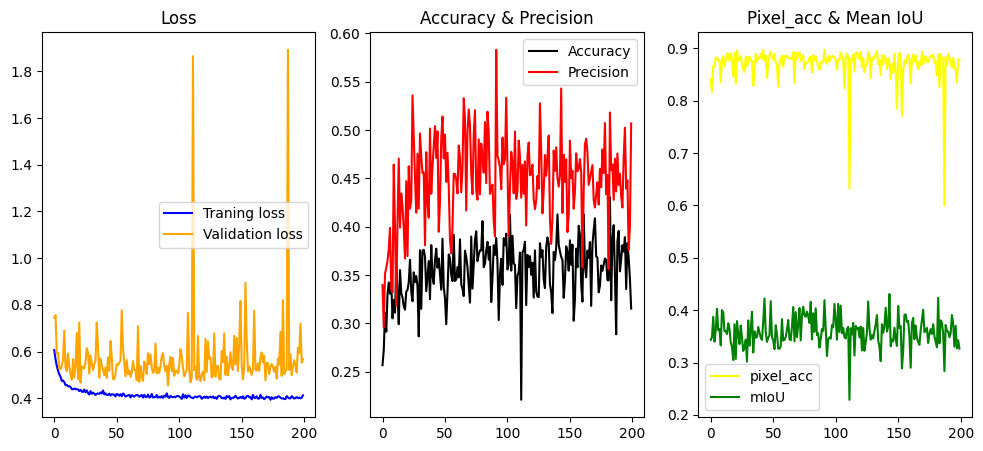

In [9]:
# Show results of training
training_loss=np.genfromtxt((Path(workspace_path)/model_folder_name/"training_loss.csv").as_posix(),dtype=None,encoding='utf-8',delimiter=',')
val_loss=np.genfromtxt((Path(workspace_path)/model_folder_name/"val_loss.csv").as_posix(),dtype=None,encoding='utf-8',delimiter=',')
val_accuracy=np.genfromtxt((Path(workspace_path)/model_folder_name/"accuracy.csv").as_posix(),dtype=None,encoding='utf-8',delimiter=',')
val_precision=np.genfromtxt((Path(workspace_path)/model_folder_name/"precision.csv").as_posix(),dtype=None,encoding='utf-8',delimiter=',')
val_pixel_wise_accuracy=np.genfromtxt((Path(workspace_path)/model_folder_name/"pixel_wise_acc.csv").as_posix(),dtype=None,encoding='utf-8',delimiter=',')
val_mIoU=np.genfromtxt((Path(workspace_path)/model_folder_name/"mIoU.csv").as_posix(),dtype=None,encoding='utf-8',delimiter=',')

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(training_loss, color='blue', label='Traning loss')
plt.plot(val_loss, color='orange', label='Validation loss')
plt.title("Loss")
plt.legend(loc='best')
plt.subplot(1, 3, 2)
plt.plot(val_accuracy, color='black', label='Accuracy')
plt.plot(val_precision, color='red', label='Precision')
plt.legend(loc='best')
plt.title("Accuracy & Precision")
plt.subplot(1, 3, 3)
plt.plot(val_pixel_wise_accuracy, color='yellow', label='pixel_acc')
plt.plot(val_mIoU, color='green', label='mIoU')
plt.legend(loc='best')
plt.title("Pixel_acc & Mean IoU")
plt.show()

In [10]:
# Testing parameters
model_file_name="model_200.pth"
model_folder_name="model_1113"
# Load testing data
color_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4044, 0.4067, 0.4069), (0.2750, 0.2738, 0.2710))
])
loading_mode="pre"
target_size=(512,512)
num_classes=25
batch_size=8
testing_dataset=CustomDataset(workspace_path,"test_data_path.csv",color_transforms,target_size,loading_mode)
testing_loader=DataLoader(testing_dataset,batch_size,shuffle=False,drop_last=True)
# Testing
torch.cuda.empty_cache()
model=deeplab_model
model.load_state_dict(torch.load((Path(workspace_path)/model_folder_name/model_file_name)))
model.to(device)
model.eval()
total_confusion_matrix = np.zeros((num_classes, num_classes))
with torch.no_grad():
    for images, labels in tqdm(testing_loader, desc="testing: ", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        out=outputs['out']
        pred_labels = torch.argmax(out, dim=1)
        pred_labels_np = pred_labels.cpu().numpy()
        labels_np = labels.cpu().numpy()
        for pred, target in zip(pred_labels_np, labels_np):
            pred = pred.flatten()
            target = target.flatten()
            mask = target != 0
            pred = pred[mask]
            target = target[mask]
            cm = confusion_matrix(target, pred, labels=np.arange(num_classes))
            total_confusion_matrix += cm
# mIou
intersection = np.diag(total_confusion_matrix)
union = total_confusion_matrix.sum(axis=1) + total_confusion_matrix.sum(axis=0) - intersection
iou=[1.0 if union[i]==0 else intersection[i] / union[i] for i in range(num_classes)]
mIoU=sum(iou[1:])/len(iou[1:])
# pixel-wise accuracy
correct_pixels = intersection.sum()
total_pixels = total_confusion_matrix.sum()
pixel_wise_acc=correct_pixels.item() / total_pixels.item()
print(f"Pixel-wise Acc: {pixel_wise_acc:.4f} MeanIoU: {mIoU:.4f}")

Load images and labels: 100%|██████████| 1924/1924 [00:02<00:00, 878.38it/s]
/tmp/ipykernel_164426/2995685936.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load

Pixel-wise Acc: 0.7140 MeanIoU: 0.2741


In [5]:
def load_image_and_label(image_path,label_path,target_size):
    image=cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size,interpolation=cv2.INTER_LINEAR)
    label=cv2.imread(label_path,cv2.IMREAD_UNCHANGED)
    label = cv2.resize(label, target_size,interpolation=cv2.INTER_NEAREST)
    return image,label

/tmp/ipykernel_201735/2289571750.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load((Path(workspace_path)/model_folder_name/model_file_nam

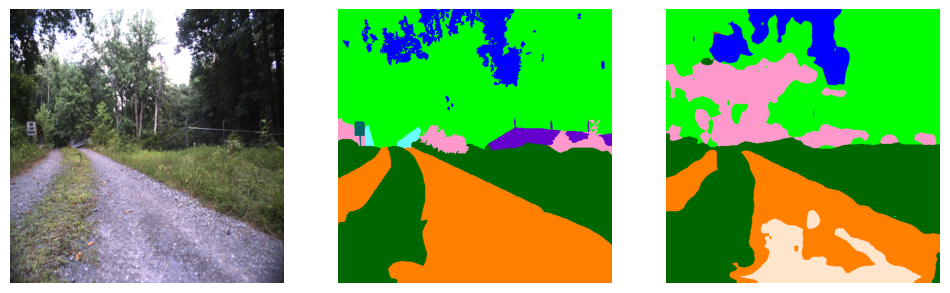

In [ ]:
model_file_name="model_200.pth"
model_folder_name="model_1113"
color_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4044, 0.4067, 0.4069), (0.2750, 0.2738, 0.2710))
])
target_size=(512,512)
image_path=Path(workspace_path)/frames_folder_name/"creek/creek_04171.png"
label_path=image_path.as_posix().replace("RUGD_frames-with-annotations", "RUGD_annotations_index")
torch.cuda.empty_cache()
model=deeplab_model
model.load_state_dict(torch.load((Path(workspace_path)/model_folder_name/model_file_name)))
model.to(device)
model.eval()
with torch.no_grad():
    image,label=load_image_and_label(image_path,label_path,target_size)
    image_tensor=color_transforms(image).unsqueeze(0)
    output= model(image_tensor.to(device))
    out=output['out']
    pred_label = torch.argmax(out, dim=1)
    pred_label_np = pred_label.cpu().numpy().reshape(512,512).astype(np.uint8)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(to_color_label(label)[:, :, ::-1])
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(to_color_label(pred_label_np)[:, :, ::-1])
plt.axis('off')
plt.show()